In [223]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Abstract

This model attempts to evaluate the socio-economic impacts of introducing a Universal Basic Income (UBI) policy. By capturing the proposed changes' microeconomic effects on individual-level behavior and then scaling to population aggregates, the model provides insights into the ripple effects of UBI on labor supply, consumption, and the broader economy. Using iterative simulations performed with flexible time horizons and granularity, the model reveals both immediate and long-term implications, offering a comprehensive understanding of UBI's potential role in modern economies.

# Outline

1. Background and Motivation
* The socio-economic rationale behind studying UBI effects.
* The potential transformative impact of UBI on modern economies.
* Initial Setup: Establishing Baseline Conditions

2. Defining the Population (initial conditions):
* Income and wealth distributions.
* Homogeneous labor behavior and consumption habits.
* Setting up tax and welfare systems:
* Introduction to the ProgressiveTax class for individual incomes.
* Current WelfarePrograms in place.

3. Introducing the UBI Model (first-order effects)
* (a). Proposal of the UBI policy:
    * Definition and attributes.
    * Cost implications and potential sources of funding.
* (b). Adjustment Mechanisms:
    * Changes and/or eliminations in existing welfare programs.
    * Alterations in the tax policy.

4. Modeling Individual Behavioral Responses to UBI:
* (a). Labor supply adjustments:
    * Income effect on labor supply using constant elasticity models.
    * Substitution effect from change in taxation using constant elsasticity models.
* (b). Consumption Responses:
    * Dynamics of individual consumption behavior in response to income changes, accounting for labor supply adjustments.

5. Aggregation: From Individual to Population Level
* Synthesizing individual behaviors to get macro-level insights.
* Assessing aggregate labor supply and overall economic consumption.
* Assessing macroeconomic multiplier effects:
    * Understanding secondary and tertiary economic ripples.
    * Impact on the economy's output, employment, and further feedback into individual behaviors.

6. Dynamic Iterations and Time Progression
* Temporal parameters:
    * Setting the time horizon n and the frequency of updates f.
* Iterative simulations:
    * Periodic recalibration based on previous results.
    * Capturing emergent behaviors and system-level adjustments over time.

# Setup

### Welfare programs

Definition: A welfare program is a government-funded initiative designed to provide financial support to individuals, particularly those in need. A welfare program is defined by the following components:
* Eligibility (E): Determines which individuals qualify for the benefits of a particular program.
* Guarantee (G): Represents the amount of aid an individual with zero income would receive from the program.
* Subsidy on Earned Income (S): A percentage of an individual's income added as an additional benefit. For example, an earned income tax credit program may have a positive subsidy.
* Maximum Grant (M): The upper limit on the amount an individual can receive from the program, regardless of their income.
* Phase-Out Income (P): The income level beyond which the benefits of the program start to decrease.
* Tax Rate on Income Above Phase-Out (T): The rate at which benefits decrease once an individual's income surpasses the phase-out level.
* Efficiency: The rate at which benefits are distributed per dollar of funding allocated to the program. For instance, a program with 70% efficiency will allocate 70 cents of every dollar to actual benefits.
* Participation Rate: The fraction of eligible individuals who actually claim and receive the benefits.

The benefit or rebate an individual X with income Y receives from the program is calculated using the formula: E(x) * min(G + S*Y, M, max[M−T(Y −P),0]).

The definition of a welfare program here is taken from https://gspp.berkeley.edu/assets/uploads/research/pdf/Hoynes-Rothstein-annurev-economics-080218-030237.pdf?fbclid=IwAR2hcERlA3xH9dl70bFW1xgI33X6F2m4oGUB72Q9_QaZ8lfCVg9_mfn_aP0

In [224]:
class WelfareProgram:
    def __init__(self, G, S, M, P, T, participation_rate=1.0, efficiency=1.0):
        self.G = G  # Grant for an individual with 0 income
        self.S = S  # Subsidy on earned income
        self.M = M  # Maximum allowable grant
        self.P = P  # Phase-out income
        self.T = T  # "Tax rate" on income above phase-out
        self.participation_rate = participation_rate  # Participation rate
        self.efficiency = efficiency  # Rate of rebates given per dollar of funding

    def calculate_rebate(self, income):
        return min(self.G + self.S * income, self.M, max(self.M - self.T * (income - self.P), 0))
    
# Test with some example welfare programs
welfare_program1 = WelfareProgram(G=2000, S=0.05, M=4000, P=100000, T=0.05, efficiency=0.7, participation_rate=0.9)
welfare_program2 = WelfareProgram(G=3000, S=0.15, M=7000, P=25000, T=0.07, efficiency=0.8, participation_rate=1.0)
welfare_programs = [welfare_program1, welfare_program2]

Text(0.5, 1.0, 'Example welfare program with G=2000, S=0.05, M=4000, P=100,000, and T=0.05')

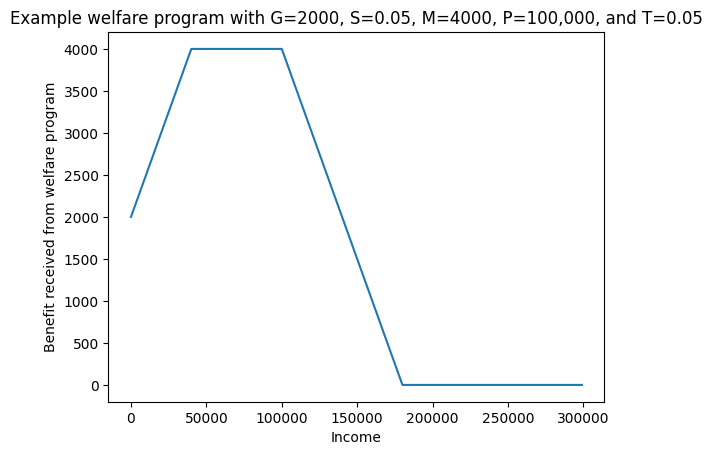

In [225]:
# Let's look at the rebate granted by welfare_program1 on individuals at different income level

x = np.arange(0, 300000, 1000)
y = list(map(lambda x: welfare_program1.calculate_rebate(x), x))

plt.plot(x, y)
plt.xlabel("Income")
plt.ylabel("Benefit received from welfare program")
plt.title("Example welfare program with G=2000, S=0.05, M=4000, P=100,000, and T=0.05")

### Population, Government, and welfare expenditures

In [226]:
# Definition of Population, Firm (not currently used), and Government

class Firm:
    def __init__(self, net_income, wealth):
        self.net_income = net_income
        self.wealth = wealth
        self.tax_paid = 0

class Population:
    def __init__(self, wealth_percentiles, income_percentiles, joint_distribution, total_count,):
        self.total_count = total_count
        self.wealth_percentiles = wealth_percentiles  # Array of length 100 for wealth values
        self.income_percentiles = income_percentiles  # Array of length 100 for income values
        self.joint_distribution = joint_distribution  # 100x100 array with joint distribution of wealth and income

    def number_of_individuals(self, wealth_index, income_index):
        """Returns the number of individuals for a specific wealth and income percentile."""
        percentage = self.joint_distribution[wealth_index][income_index]
        return self.total_count * percentage
    
# Used to calculate the cost of UBI or any other welfare program
def calculate_total_cost(welfare_program: WelfareProgram, population: Population):
    total_cost = 0

    # Loop over the joint distribution
    for i in range(100):  # loop over wealth percentiles
        for j in range(100):  # loop over income percentiles
            average_income = population.income_percentiles[j]
            average_wealth = population.wealth_percentiles[i]

            # Compute benefit for an individual in this bin
            E = .5  # Eligibility set to constant .5 for now - we can change to a function of wealth and income percentiles
            individual_benefit = E * min(welfare_program.G + welfare_program.S * average_income, welfare_program.M, 
                                         max([welfare_program.M - welfare_program.T * (average_income - welfare_program.P), 0]))

            # Multiply the individual benefit by number of individuals in this bin to get total benefit for the bin
            total_benefit_for_bin = individual_benefit * population.number_of_individuals(i, j)

            # Calculate total cost of providing the benefit for this bin
            bin_cost = total_benefit_for_bin / welfare_program.efficiency

            # Accumulate the cost
            total_cost += bin_cost

    return total_cost

class Government:
    def __init__(self):
        self.revenue = 0
        self.non_welfare_expenditure = 1000000  # Placeholder
        # Other government budget attricutes

    def total_expenditure(self, welfare_programs, population):
        welfare_expenditures = sum([calculate_total_cost(program, population) for program in welfare_programs])
        return self.non_welfare_expenditure + welfare_expenditures

A UBI is a case of WelfareProgram where G is set very high (e.g. at the poverty line), S = 0, M=G, P is either very high or non-existent, and T is very low or 0.

In [227]:
# Global constant for poverty line
POVERTY_LINE = 12700  # Placeholder value, adjust as needed

# UBI policy definition
class UBIProgram(WelfareProgram):
    def __init__(self, alpha, efficiency=1.0):
        G = alpha * POVERTY_LINE
        S = 0  # No subsidy on earned income for UBI
        M = G  # Maximum allowable grant is the same as G for UBI
        P = float('inf')  # No phase-out for UBI
        T = 0  # No tax rate on income above phase-out for UBI
        participation_rate = 1.0  # 100% participation rate
        super().__init__(G, S, M, P, T, efficiency, participation_rate)

In [228]:
class ProgressiveTax:
    def __init__(self, brackets):
        """
        Initialize with a dictionary representing the tax brackets.

        :param brackets: Dictionary where `income: rate` represents the marginal tax rate beginning at `income` and
                         ending at the value of the next key.
        """
        # Sort the brackets based on income
        self.brackets = dict(sorted(brackets.items()))

    def compute_tax(self, income):
        """
        Compute the tax for a given income based on the progressive tax brackets.

        :param income: Income for which to compute the tax.
        :return: Computed tax.
        """
        tax = 0
        previous_bracket_limit = 0

        # Iterate through the sorted brackets
        for bracket_limit, rate in self.brackets.items():
            # If income is within the current bracket
            if income <= bracket_limit:
                tax += (income - previous_bracket_limit) * rate
                return tax
            else:
                # Compute tax for the entire bracket range and move to the next
                tax += (bracket_limit - previous_bracket_limit) * rate
                previous_bracket_limit = bracket_limit

        # If income is beyond the highest bracket, apply the highest rate to the remainder
        tax += (income - previous_bracket_limit) * rate
        return tax

tax_brackets = {
    10000: 0.1,   # 10% for income <= 10,000
    50000: 0.2,  # 20% for income between 10,001 and 50,000
    100000: 0.3  # 30% for income > 50,000
}
progressive_tax = ProgressiveTax(tax_brackets)
print(progressive_tax.compute_tax(20000))  # Example usage

3000.0


In [229]:
class TaxPolicy:
    def __init__(self, individual_tax_policy, corporate_tax_policy, other_tax_params):
        """
        Initialize the TaxPolicy with individual and corporate progressive tax policies.

        :param individual_tax_policy: A ProgressiveTax object for individual income tax.
        :param corporate_tax_policy: A ProgressiveTax object for corporate tax.
        :param other_tax_params: Parameters for other taxes. This can be expanded upon.
        """
        self.individual_tax_policy = individual_tax_policy
        self.corporate_tax_policy = corporate_tax_policy
        self.other_tax_params = other_tax_params

    def individual_income_tax(self, individual_income):
        """
        Compute individual income tax based on the given income and the tax policy.

        :param individual_income: The income for which to compute the tax.
        :return: Computed tax.
        """
        return self.individual_tax_policy.compute_tax(individual_income)

    def corporate_tax(self, corporate_income):
        """
        Compute corporate tax based on the given corporate income and the tax policy.

        :param corporate_income: The corporate income for which to compute the tax.
        :return: Computed tax.
        """
        return self.corporate_tax_policy.compute_tax(corporate_income)

    def other_taxes(self):
        # Compute other taxes.
        # Placeholder for now; this can be expanded upon based on the nature of other taxes.
        pass

    def total_individual_income_tax_revenue(self, population):
        """
        Compute the total revenue from individual income taxes based on the population's income distribution.

        :param population: Population object with joint distribution of income and wealth.
        :return: Total revenue from individual income taxes.
        """
        total_revenue = 0

        # Iterate over the income percentiles
        for j in range(100):
            average_income = population.income_percentiles[j]
            tax_for_income_bin = self.individual_income_tax(average_income)

            # For each wealth percentile, compute the number of individuals and add to the total revenue
            for i in range(100):
                total_revenue += tax_for_income_bin * population.number_of_individuals(i, j)

        return total_revenue

## Effects on individual behavior

We now switch to examining individual consumer behavior: namely, preferences detailing their consumption demand and labor supply functions.

Homogeneous Agents: We'll use a representative agent model, where one agent's behavior is representative of the entire population.

Focus on Consumption: Given an income (which might include UBI), the representative agent decides how much to consume. This will be based on a simple utility function of consumption.

Fixed Prices: Prices of goods and services are constant. We'll note to reintroduce inflationary considerations in future iterations.

Simple Tax and UBI System: We will implement the UBI policy and tax system we've defined so far to see how the introduction of UBI affects the representative agent's income and thus consumption.

Once we've modeled effects on individual behavior, we will aggregate these to the level of a Population of individuals with homogeneous preferences

Now, let's proceed by building the model with these considerations:

In [239]:
class Individual:
    def __init__(self,
        # Income / wealth paramslabor supply params
        wage,
        savings = 100_000,
        labor_hours=2000,
        # Labor supply params
        elasticity_income = -0.1,
        elasticity_wealth = -0.1,
        # MPC params
        alpha=0.4,
        beta=0.3,
        gamma=0.5,
        delta=0.15,
        zeta=0.3,
        welfare_programs=[],
        tax_policy=None
        ):
        self.wage = wage
        # Assume constant elasticity of income and wealth
        self.elasticity_income_income_effect = elasticity_income # ONLY MEASURING INCOME EFFECT Why? because wages DO NOT CHANGE, so there's no substitution effect
        # You can think about this as a bestowal of 1 good, but the price remains the same

        # TODO: We will also require an elasticity_income_substitution_effect when considering the effects of changing the tax policy to fund UBI
        
        # We will consider UBI as an income stream, not a wealth shock. Maybe in the future we will want to consider previous years' income
        # differences as a wealth shock
        self.elasticity_wealth_marshallian = elasticity_wealth # Compensated (Marshallian)
        self.total_hours = labor_hours
        self.welfare_programs = welfare_programs
        self.tax_policy = tax_policy
        self.wealth = savings

        """
        PARAMS for MPC:
        alpha: 0.4 (baseline MPC, based on the 2008 economic stimulus paper:
        Parker, J. A., Souleles, N. S., Johnson, D. S., & McClelland, R. (2013).
            Consumer spending and the economic stimulus payments of 2008. American Economic Review, 103(6), 2530-53.
        beta: 0.3 (representing sensitivity to income; this is speculative and would need empirical grounding)
        gamma: 0.5 (rate of decrease of the MPC as income increases; again, this is speculative)
        delta: 0.15 (representing sensitivity to wealth (in 1000s of dollars); speculative)
        zeta: 0.03 (rate of decrease of the MPC as wealth increases; speculative)

        These numbers are estimated from the following research:
        Parker, J. A. (2000). The Reaction of Household Consumption to Predictable Changes in Social Security Taxes.
        Johnson, D., Parker, J. A., & Souleles, N. S. (2006). Household Expenditure and the Income Tax Rebates of 2001. American Economic Review.
        Jappelli, T., & Pistaferri, L. (2010). The Consumption Response to Income Changes. Annual Review of Economics.
        """
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.zeta = zeta


    def non_labor_income(self, labor_hours):
        """Compute non-labor income based on welfare programs."""
        income = self.wage * labor_hours
        benefits = sum([program.calculate_rebate(income) for program in self.welfare_programs])
        return benefits

    def taxes_paid(self, labor_hours):
        """Compute taxes paid based on tax policy."""
        income = self.wage * labor_hours
        return self.tax_policy.compute_tax(income)

    # TODO: modify later to include substitution effect due to changing taxes. Note that we will also need a method to compute delta_wage_after_tax for 2 tax policies
    def adjust_labor_supply(self, delta_income, delta_wealth = 0):
        """Adjust labor supply based on changes in income and wealth."""
        delta_l = self.elasticity_income_income_effect * delta_income + self.elasticity_wealth_marshallian * delta_wealth
        adjusted_hours = self.total_hours + delta_l * self.total_hours
        return max(0, min(self.total_hours, adjusted_hours))  # Ensuring labor supply is between 0 and total_hours

    def compute_net_income(self):
        """Compute net income after accounting for taxes and welfare benefits."""
        gross_income = self.wage * self.total_hours
        total_benefits = self.non_labor_income(self.total_hours)
        total_taxes = self.taxes_paid(self.total_hours)
        return gross_income + total_benefits - total_taxes
    
    def MPC(self):
        """Compute the marginal propensity to consume based on income and wealth."""
        return self.alpha + self.beta * np.exp(-self.gamma * self.compute_net_income() / POVERTY_LINE) + self.delta * np.exp(-self.zeta * self.wealth / POVERTY_LINE)
    
    def MPS(self):
        """Compute the marginal propensity to consume based on income and wealth."""
        return 1 - self.MPC()

Let's test our utility optimization. We'll consider an individual earning  wage of 25 under a progressive income tax poloicy and receiving benefits from an EITC program. 

In [240]:
tax_brackets = {
    9700: 0.10,
    39475: 0.12,
    84200: 0.22,
    160725: 0.24,
    204100: 0.32,
    510300: 0.35
}
tax_policy = ProgressiveTax(tax_brackets)

EITC_params = {
    'G': 0, 
    'S': 6557/19030,
    'M': 6557,
    'P': 19030,
    'T': (6557 / (50162 - 19030))
}
EITC_program = WelfareProgram(**EITC_params)


### Effects on labor supply for an individual (test)

In [241]:
wage = 25 # $/hour
initial_working_hours = 2000 # hours/year

individual = Individual(wage=wage, 
                        elasticity_income=-0.1, 
                        elasticity_wealth=-0.1, 
                        labor_hours=initial_working_hours, 
                        welfare_programs=[EITC_program], 
                        tax_policy=tax_policy)

initial_net_income = individual.compute_net_income()
print(f"Initial net income: ${initial_net_income:.2f}")

delta_income = 12000 / initial_net_income

adjusted_hours = individual.adjust_labor_supply(delta_income, 0)
print(f"Adjusted labor supply: {adjusted_hours:.2f} hours/year")
# Our model predicts that someone working 2000 hours at $25 / hour pre-UBI with an EITC will work 1927.65 hours / year post-UBI - not taking into account the
# substitution effect of income changes

Initial net income: $43175.62
Adjusted labor supply: 1944.41 hours/year


In [242]:
individual.MPC()

0.46894635025271486

### Aggregate effects on labor supply ceteris paribus

In [243]:
def apply_ubi_income_shock(population: Population, UBI_amount: float):
    """Applies a UBI income shock to each slice of the population."""
    initial_hours = 2000

    new_labor_hours = np.zeros((100, 100))
        
    for i, income in enumerate(population.income_percentiles):
        for j, wealth in enumerate(population.wealth_percentiles):
            individual = Individual(wage=income/initial_hours, 
                elasticity_income=-0.2,  # Using the earlier assumed values 
                elasticity_wealth=0,
                labor_hours=initial_hours,
                welfare_programs=[EITC_program],
                tax_policy=tax_policy)
            delta_income = UBI_amount / (individual.compute_net_income())
            new_hours = individual.adjust_labor_supply(delta_income, 0)  # 0 wealth effect
            new_labor_hours[i][j] = new_hours
    
    return new_labor_hours

def compute_average_labor(population: Population, labor_hours: np.ndarray):
    avg_labor = 0
    for i in range(100):
        for j in range(100):
            avg_labor += population.joint_distribution[i][j] * labor_hours[i][j]
    return avg_labor

Setting up a test case:

* Income Percentiles: We'll assume a progressive increase where the 1st percentile earns $5,000 annually, and the 100th percentile earns $500,000.
* Wealth Percentiles: Wealth distribution is more skewed than income. So, let's say the 1st percentile has wealth of $500, and the 100th percentile has wealth of $5 million.
* Joint Distribution: Let's assume a positive correlation between income and wealth but with some randomness to capture that they're not perfectly correlated.

In [244]:
# Creating hypothetical income and wealth percentiles
income_percentiles = np.linspace(10000, 500000, 100)
wealth_percentiles = np.linspace(500, 5000000, 100)

# Creating a hypothetical joint distribution
joint_distribution = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        if abs(i-j) < 10:  # Considering people within 10 percentiles of each other in income and wealth
            joint_distribution[i][j] = 1
joint_distribution = joint_distribution / joint_distribution.sum()  # Normalize to make sure it sums up to 1

# Setting up the population
population = Population(wealth_percentiles, income_percentiles, joint_distribution, total_count=331e6)

# Applying UBI income shock and computing the average labor
UBI_amount = 12000
new_labor_hours = apply_ubi_income_shock(population, UBI_amount)
avg_hours = compute_average_labor(population, new_labor_hours)

print(f"Average working hours after UBI introduction: {avg_hours:.2f} hours/year")

Average working hours after UBI introduction: 1958.72 hours/year


### Effects on individual consumption

In [245]:
def compute_consumption_change(disposable_income_change, MPC):
    """Compute the change in consumption based on a change in disposable income."""
    return disposable_income_change * MPC

In [246]:
def MPC(I, S, P = POVERTY_LINE, alpha=0.4, beta=0.3, gamma=0.5, delta=0.15, eta=0.3):
    """
    Calculate the Marginal Propensity to Consume (MPC) based on income (I), savings (S), and the poverty line (P).
    
    Parameters:
    - I: Income
    - S: Savings
    - P: Poverty line
    - alpha, beta, gamma, delta, eta: coefficients for the MPC function
    
    Returns:
    - Estimated MPC value
    """
    I_prime = I / P
    S_prime = S / P
    
    mpc_value = alpha + beta * np.exp(-gamma * I_prime) + delta * np.exp(-eta * S_prime)
    return mpc_value

# Example Usage
poverty_line = 30000  # Just a hypothetical value for the poverty line, adjust as needed
income = 50000
savings = 10000
print(MPC(income, savings, poverty_line))


0.6661050752575174


Let's take a look at how our hypothetical MPC varies over a reasonable range of (income, savings) levels

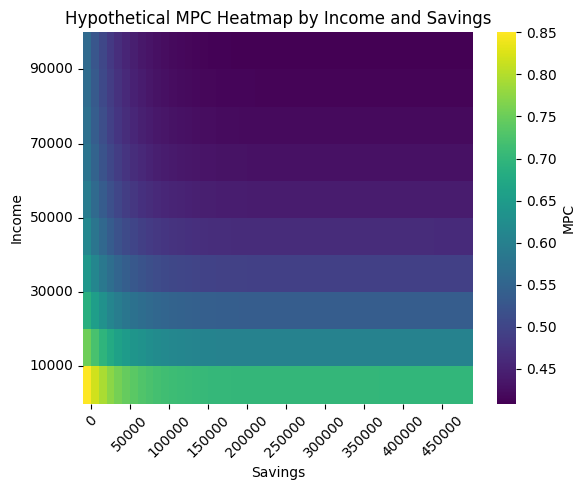

In [247]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

example_incomes = np.array(range(0, 100_000, 10_000))
example_savings = np.array(range(0, 500_000, 10_000))

I_S_pairs = list(cartesian_product(example_incomes, example_savings))

MPC_default_values = lambda I_S_pair: MPC(I_S_pair[0], I_S_pair[1])
MPCs = np.array(list(map(MPC_default_values, I_S_pairs)))
MPCs_2D = MPCs.reshape((len(example_incomes), len(example_savings)))

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(np.flipud(MPCs_2D), cmap='viridis', cbar_kws={'label': 'MPC'})
ax.set_title("Hypothetical MPC Heatmap by Income and Savings")
ax.set_ylabel("Income")
ax.set_xlabel("Savings")

# Setting tick positions and labels excluding zero for a log scale
y_ticks = np.arange(1, len(example_incomes), 2)
y_ticklabels = example_incomes[::-2]  # Excluding first value (zero), and reversed
x_ticks = np.arange(1, len(example_savings), 5)
x_ticklabels = example_savings[::5]  # Excluding first value (zero)

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels, rotation=0)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, rotation=45)

plt.tight_layout()
plt.show()